In [31]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import os 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader

# Step 1: Forward Process = Adding Noise

In [3]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# DEFINE BETA SCHEDULE
T = 300
betas = linear_beta_schedule(timesteps=T)

# PRE-CALCULATE DIFFERENT TERMS FOR CLOSED FORM
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

#### Create dataset of video frames

In [39]:
class FireFrameDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.frame_dir = os.path.join(data_dir, "frames")
        self.transform = transform
        self.file_list = os.listdir(self.frame_dir)
        
        self.images = []
        for file_name in self.file_list:
            file_path = os.path.join(self.frame_dir, file_name)
            with open(file_path, 'rb') as f:
                images = pickle.load(f)

            # Normalize images and flatten them
            images = np.array(images)  # shape: (20, 128, 128, 3)
            images = images.astype(np.float32) / 255.0  # normalize pixel values
            images = images.reshape(-1, 3, 128, 128)  # shape: (20, 3, 128, 128)
            self.images.extend(images)
        
    def __len__(self):
        return len(self.images) - 1
    
    def __getitem__(self, idx):
        current_image = self.images[idx]
        # Handle wrap-around for the last index
        next_idx = (idx + 1) % len(self.images)
        next_image = self.images[next_idx]

        # Convert numpy arrays to PyTorch tensors
        current_image_tensor = torch.from_numpy(current_image)
        next_image_tensor = torch.from_numpy(next_image)

        # Apply transformations if provided
        if self.transform:
            current_image_tensor = self.transform(current_image_tensor)
            next_image_tensor = self.transform(next_image_tensor)

        return current_image_tensor, next_image_tensor
    
data_dir = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data"
data_transforms = [
        transforms.RandomHorizontalFlip(),
        # transforms.ToTensor(), # scale to [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # scale to [-1,1]
    ]
    
data_transform = transforms.Compose(data_transforms)
dataset = FireFrameDataset(data_dir, transform=data_transform)        

In [40]:
# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for iterating over the dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Apply forward pass on Dataset

In [41]:
IMG_SIZE = 128
BATCH_SIZE = 32

def show_tensor_image(image):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t  * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transform(image))

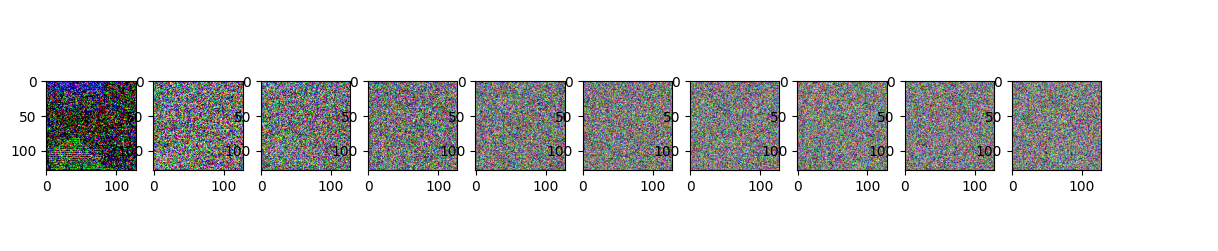

In [45]:
image = next(iter(train_loader))[0]

plt.figure(figsize=(15, 3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)